**Brian Blaylock**  
**April 4, 2019**

# **Fig. 7** Hovemoller Scores

![](./figs/Fig-07a_HOV_skill_HRRR.png)

> Caption

NOTE: Probability of Detection (POD) is the same thing as Hit Rate (HR)  
NOTE: Equitable Threat Score (ETS) is the same thing as Gilbert Skill Score (GSS)

NOTE: We want the peak lightning activity to be in the center of the plot (not the edges)

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os
from matplotlib.path import Path

import itertools

In [2]:
import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3')
from BB_maps.my_basemap import draw_HRRR_map, draw_centermap
from BB_HRRR.HRRR_Pando import get_hrrr_latlon, get_hrrr_variable
from BB_HRRR.GLM_and_HRRR.GLM_events_HRRR import get_GLM_HRRR_contingency_stats,\
                                                 hit_rate, \
                                                 false_alarm_ratio, \
                                                 equitable_threat_score, base_rate, \
                                                 forecast_rate, frequency_bias, \
                                                 proportion_correct
from BB_GOES.get_GLM import get_GLM_file_nearesttime, accumulate_GLM_FAST

Create HRRR map.
loaded /uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_maps/saved_map_objects/HRRR_lcc_c_2000.npy map from file
Forecasts [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
Generate domains and masks.
HRRR Area in meters squared: 16811840278558.668
West Area in meters squared: 4034896806752.7593
Central Area in meters squared: 4034896806752.766
East Area in meters squared: 4034896806752.762
Utah Area in meters squared: 219973261639.39685
Colorado Area in meters squared: 269906899003.7569
Texas Area in meters squared: 688270731111.2987
Florida Area in meters squared: 149996892486.02234
dict_keys(['HRRR', 'West', 'Central', 'East', 'Utah', 'Colorado', 'Texas', 'Florida'])


In [3]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [6.5, 3.5]
mpl.rcParams['figure.titlesize'] = 10
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['xtick.labelsize'] = 6
mpl.rcParams['ytick.labelsize'] = 6
mpl.rcParams['axes.labelsize'] = 6
mpl.rcParams['axes.titlesize'] = 8
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['grid.linewidth'] = .25
mpl.rcParams['figure.subplot.wspace'] = 0.05
mpl.rcParams['figure.subplot.hspace'] = 0.05
mpl.rcParams['legend.fontsize'] = 6
mpl.rcParams['legend.framealpha'] = .75
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.dpi'] = 600

In [4]:
def get_traditional_scores(sDATE, eDATE, DOMAIN):
    file_dates = [datetime(sDATE.year, m, 1) for m in range(sDATE.month, eDATE.month+1)]
    samples = []
    first = True
    for hour in HOURS:
        mean_POD = []
        mean_FAR = []
        mean_ETS = []
        mean_BRS = []  # mean base rate (s); probability of observing a categorical event.
        mean_FRR = []  # mean forecast rate (r): probability of forecasting a categorical event.
        mean_FBB = []  # mean frequency bias (B): r/s

        DIR = '/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_HRRR/GLM_and_HRRR/HRRR_GLM_contingency_table'
        files = []
        for DATE in file_dates:
            FILE = '/%s/%s_%s_m%02d_h%02d.csv' % (DOMAIN, DOMAIN, DATE.year, DATE.month, hour)
            files.append(DIR+FILE)

        data = [np.genfromtxt(FILE, delimiter=',', names=True, dtype=None, encoding='UTF-8') for FILE in files]

        dates = np.array(list(itertools.chain(*[data[i]['DATE'] for i in range(len(files))])))
        DATES = np.array([])
        for D in dates:
            try:
                DATES = np.append(DATES, datetime.strptime(D, '%Y-%m-%d %H:%M:%S'))
            except:
                DATES = np.append(DATES, datetime.strptime(D, '%m/%d/%Y %H:%M'))
        date_boolean = np.array([np.logical_and(D>=sDATE, D<eDATE) for D in DATES])
        DATES = DATES[date_boolean]
        samples.append(len(DATES))
        
        EVENTS = np.array(list(itertools.chain(*[data[i]['GLM_Event_COUNT'] for i in range(len(files))])))
        EVENTS = EVENTS[date_boolean]

        for f in list(range(1,19))+[18]:
            # Get A, B, C, D values for dates within requested DATES with date_boolean
            A = np.array(list(itertools.chain(*[data[i]['F%02d_A' % f] for i in range(len(files))])))[date_boolean]
            B = np.array(list(itertools.chain(*[data[i]['F%02d_B' % f] for i in range(len(files))])))[date_boolean]
            C = np.array(list(itertools.chain(*[data[i]['F%02d_C' % f] for i in range(len(files))])))[date_boolean]
            D = np.array(list(itertools.chain(*[data[i]['F%02d_D' % f] for i in range(len(files))])))[date_boolean]

            # nan will occur if there are no GLM observations. These are few (<<1% of times between May-October)
            mean_POD.append(np.nanmean(hit_rate(A, B, C, D)))
            mean_FAR.append(np.nanmean(false_alarm_ratio(A, B, C, D)))
            mean_ETS.append(np.nanmean(equitable_threat_score(A, B, C, D)))
            mean_BRS.append(np.nanmean(base_rate(A, B, C, D)))
            mean_FRR.append(np.nanmean(forecast_rate(A, B, C, D)))
            mean_FBB.append(np.nanmean(frequency_bias(A, B, C, D)))

        if first:
            mean_POD_HOV = np.array(mean_POD)
            mean_FAR_HOV = np.array(mean_FAR)
            mean_ETS_HOV = np.array(mean_ETS)
            mean_BRS_HOV = np.array(mean_BRS)
            mean_FRR_HOV = np.array(mean_FRR)
            mean_FBB_HOV = np.array(mean_FBB)
        else:
            mean_POD_HOV = np.vstack([mean_POD_HOV, mean_POD])
            mean_FAR_HOV = np.vstack([mean_FAR_HOV, mean_FAR])
            mean_ETS_HOV = np.vstack([mean_ETS_HOV, mean_ETS])
            mean_BRS_HOV = np.vstack([mean_BRS_HOV, mean_BRS])
            mean_FRR_HOV = np.vstack([mean_FRR_HOV, mean_FRR])
            mean_FBB_HOV = np.vstack([mean_FBB_HOV, mean_FBB])
    
        first = False
    return {'POD': np.transpose(mean_POD_HOV),
            'FAR': np.transpose(mean_FAR_HOV),
            'ETS': np.transpose(mean_ETS_HOV),
            'Base Rate': np.transpose(mean_BRS_HOV),
            'Forecast Rate': np.transpose(mean_FRR_HOV),
            'Frequency Bias': np.transpose(mean_FBB_HOV),
            'DATES': DATES,
            'EVENTS': EVENTS,
            'SAMPLES': samples}

In [5]:
num = np.array([1, 2, np.nan, 4])
sum(np.isnan(num))

1

In [10]:
def get_fss_scores(sDATE, eDATE, DOMAIN, radius):
    file_dates = [datetime(sDATE.year, m, 1) for m in range(sDATE.month, eDATE.month+1)]
    samples = []
    empty_days = 0
    first = True
    for hour in HOURS:
        mean_FSS = []

        DIR = '/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_HRRR/GLM_and_HRRR/HRRR_GLM_Fractions_Skill_Score_r%02d/' % radius
        files = []
        for DATE in file_dates:
            FILE = '/%s/%s_%s_m%02d_h%02d.csv' % (DOMAIN, DOMAIN, DATE.year, DATE.month, hour)
            files.append(DIR+FILE)

        data = [np.genfromtxt(FILE, delimiter=',', names=True, dtype=None, encoding='UTF-8') for FILE in files]

        dates = np.array(list(itertools.chain(*[data[i]['DATE'] for i in range(len(files))])))
        DATES = np.array([])

        for D in dates:
            try:
                DATES = np.append(DATES, datetime.strptime(D, '%Y-%m-%d %H:%M:%S'))
            except:
                DATES = np.append(DATES, datetime.strptime(D, '%m/%d/%Y %H:%M'))
        date_boolean = np.array([np.logical_and(D>=sDATE, D<eDATE) for D in DATES])
        DATES = DATES[date_boolean]
        samples.append(len(DATES))

        for f in list(range(1,19))+[18]:
            # Get A, B, C, D values for dates within requested DATES with date_boolean
            FSS = np.array(list(itertools.chain(*[data[i]['F%02d_FSS' % f] for i in range(len(files))])))[date_boolean]
            mean_FSS.append(np.nanmean(FSS))
            #print(sum(np.isnan(FSS)))

        if first:
            mean_FSS_HOV = np.array(mean_FSS)
        else:
            mean_FSS_HOV = np.vstack([mean_FSS_HOV, mean_FSS])

        first = False
    return {'FSS': np.transpose(mean_FSS_HOV),
            'DATES': DATES,
            'SAMPLES': samples,
            'empty days': empty_days}

In [7]:
HOURS = list(range(12,24))+list(range(0,12))+[12, 13]
HOURS[::3]

[12, 15, 18, 21, 0, 3, 6, 9, 12]

In [107]:
FSS[20]['SAMPLES']

[92,
 92,
 92,
 92,
 92,
 92,
 92,
 92,
 92,
 92,
 92,
 92,
 92,
 92,
 92,
 92,
 92,
 92,
 92,
 92,
 92,
 92,
 92,
 92,
 92,
 92]

---
# Hovemollers Departure from HRRR
Compare a domains again the HRRR-wide statistics

Working on West 2018-07-13 00:00:00 2018-09-01 00:00:00


/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_wx_calcs/binary_events.py:127: RuntimeWarning: invalid value encountered in true_divide
  H = a/(a+c)
/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_wx_calcs/binary_events.py:112: RuntimeWarning: divide by zero encountered in true_divide
  B = (a+b)/(a+c)
/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_wx_calcs/binary_events.py:154: RuntimeWarning: invalid value encountered in true_divide
  FAR = b/(a+b)
/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_wx_calcs/binary_events.py:228: RuntimeWarning: invalid value encountered in true_divide
  GSS = (a-a_r)/(a+b+c-a_r)
/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_wx_calcs/binary_events.py:112: RuntimeWarning: invalid value encountered in true_divide
  B = (a+b)/(a+c)


saved: West
Working on Central 2018-07-13 00:00:00 2018-09-01 00:00:00
saved: Central
Working on East 2018-07-13 00:00:00 2018-09-01 00:00:00


/uufs/chpc.utah.edu/common/home/u0553130/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


saved: East
Sta Date: 0000 UTC 13 July 2018
End Date: 0000 UTC 01 September 2018
Contingency Table Samples: 50
       FSS Scores Samples: 50


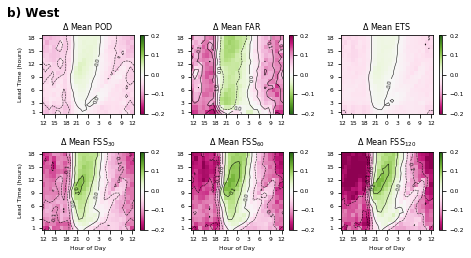

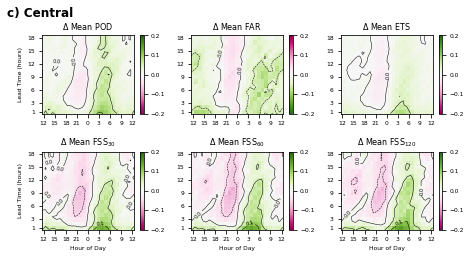

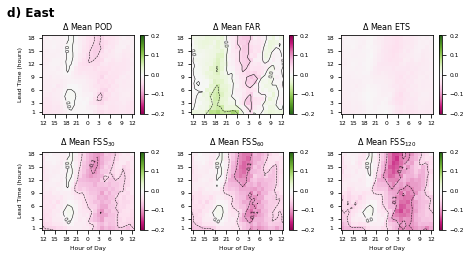

In [11]:
sDATE = datetime(2018, 7, 13)
eDATE = datetime(2018, 9, 1)

radii = [10, 20, 40]
reference_DOMAIN = 'HRRR'
domains = ['West', 'Central', 'East']
labels = ['b)', 'c)', 'd)']

for DOMAIN, label in zip(domains, labels):
    print('Working on %s %s %s' % (DOMAIN, sDATE, eDATE))
    
    # Scores for requested domain (subregion)
    CT = get_traditional_scores(sDATE, eDATE, DOMAIN)
    FSS = {}
    for r in radii:
        FSS[r] = get_fss_scores(sDATE, eDATE, DOMAIN, r)
    
    # Scores for reference domain (HRRR)
    CT_HRRR = get_traditional_scores(sDATE, eDATE, reference_DOMAIN)
    FSS_HRRR = {}
    for r in radii:
        FSS_HRRR[r] = get_fss_scores(sDATE, eDATE, reference_DOMAIN, r)
        
    #        [ax, data, vmax, vmin, cmap, name]
    plots = [[0, CT['POD']-CT_HRRR['POD'], .2, -.2, 'PiYG', 'POD'], 
             [1, CT['FAR']-CT_HRRR['FAR'], .2, -.2, 'PiYG_r', 'FAR'], 
             [2, CT['ETS']-CT_HRRR['ETS'], .2, -.2, 'PiYG', 'ETS']]
    
    for idx, r in zip(range(3,3+len(radii)), radii):
        plots.append([idx, FSS[r]['FSS']-FSS_HRRR[r]['FSS'], .2, -.2, 'PiYG', r'FSS$\mathregular{_{%s}}$' % (r*3)])


    fig, axes = plt.subplots(2,3)
    axes = axes.flatten()

    for p in plots:
        ax, data, vmax, vmin, cmap, name = p
        plt.sca(axes[ax])
        plt.pcolormesh(range(26), range(1,20), data, vmax=vmax, vmin=vmin, cmap=cmap)
        plt.colorbar(pad=.05, ticks=np.arange(vmin, vmax+.01, .1))

        # Plot Contour with label at 0.1 interval
        levels = np.arange(-.1,2,.1)
        CS = plt.contour(range(26), range(1,20), data, colors='k', linewidths=.5, levels=levels)
        plt.clabel(CS, fmt='%1.1f', fontsize=5, inline_spacing=1) # Only label every other
        # Plot Contour WITHOUT label at 0.05 interval
        levels = np.arange(-.15,2,.1)
        CS = plt.contour(range(26), range(1,20), data, colors='k', linewidths=.5, levels=levels)
 
        plt.yticks(np.array([1, 3, 6, 9, 12, 15, 18])+.5, [1, 3, 6, 9, 12, 15, 18])
        plt.xticks(np.array(range(0,25,3))+.5, np.array(HOURS[::3]), )

        if ax in [0, 3]:
            plt.ylabel('Lead Time (hours)')
        
        if ax in [3, 4, 5]:
            plt.xlabel('Hour of Day')
            
        plt.title(r'$\Delta$ Mean %s' % name)

    plt.suptitle('%s %s' % (label, DOMAIN), y=1.01, x=0, ha='left', fontsize=12)
    fig.tight_layout()

    plt.savefig('./figs/Fig-07%s_HOV_skill_%s_DIFF.png' % (label[0],DOMAIN))
    print('saved:', DOMAIN)

    #if DOMAIN != 'HRRR':
    #    plt.close()
        
print('Sta Date:', sDATE.strftime('%H%M UTC %d %B %Y'))
print('End Date:', eDATE.strftime('%H%M UTC %d %B %Y'))
        
# Numnber of samples
print('Contingency Table Samples:', len(CT['DATES']))
print('       FSS Scores Samples:', len(FSS[10]['DATES']))

# Mean Base Rate
Probability that observation of categorical event will occur.

In [44]:
sDATE = datetime(2018, 7, 13)
eDATE = datetime(2018, 9, 1)

radii = [10, 20, 40]

domains = ['HRRR', 'West', 'Central', 'East']
labels = ['a)', 'b)', 'c)', 'd)']

for DOMAIN, label in zip(['HRRR'], ['a)']):
#for DOMAIN, label in zip(domains, labels):
    print('Working on %s %s %s' % (DOMAIN, sDATE, eDATE))
    CT = get_traditional_scores(sDATE, eDATE, DOMAIN)

Working on HRRR 2018-07-13 00:00:00 2018-09-01 00:00:00


(0.058256223555106935,
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17]),
  array([22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22,
         22])))

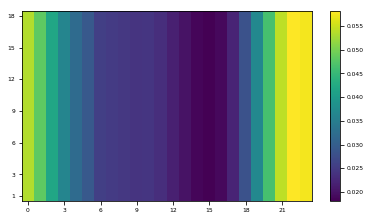

In [60]:
plt.figure()
plt.pcolormesh(range(25), range(1,20), CT['Base Rate'])
plt.colorbar()

plt.yticks(np.array([1, 3, 6, 9, 12, 15, 18])+.5, [1, 3, 6, 9, 12, 15, 18])
plt.xticks(np.arange(0,24,3)+.5, range(0,24,3), )

np.max(CT['Base Rate']), np.where(CT['Base Rate'] == np.max(CT['Base Rate']))

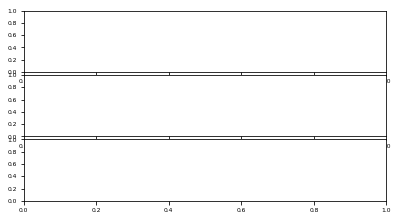

In [62]:
fig, axes = plt.subplots(3,1)

In [88]:
np.shape(CT['Base Rate'][0]), np.shape(range(24))

((24,), (24,))

In [122]:
MAX, MAXTIME

(0.02140012061627524, 12)

---
Base Rate
Base Rate Maximum HRRR: 0.054 at 2200 UTC
Base Rate Minimum HRRR: 0.017 at 1500 UTC



/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_wx_calcs/binary_events.py:127: RuntimeWarning: invalid value encountered in true_divide
  H = a/(a+c)
/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_wx_calcs/binary_events.py:112: RuntimeWarning: divide by zero encountered in true_divide
  B = (a+b)/(a+c)
/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_wx_calcs/binary_events.py:154: RuntimeWarning: invalid value encountered in true_divide
  FAR = b/(a+b)
/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_wx_calcs/binary_events.py:228: RuntimeWarning: invalid value encountered in true_divide
  GSS = (a-a_r)/(a+b+c-a_r)
/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_wx_calcs/binary_events.py:112: RuntimeWarning: invalid value encountered in true_divide
  B = (a+b)/(a+c)


---
Base Rate
Base Rate Maximum West: 0.064 at 2300 UTC
Base Rate Minimum West: 0.003 at 1600 UTC

---
Base Rate
Base Rate Maximum Cent: 0.066 at 2200 UTC
Base Rate Minimum Cent: 0.024 at 1600 UTC

---
Base Rate
Base Rate Maximum East: 0.085 at 2100 UTC
Base Rate Minimum East: 0.030 at 1400 UTC

---
Forecast Rate
Forecast Rate Maximum HRRR: 0.021 at 0000 UTC
Forecast Rate Minimum HRRR: 0.009 at 1700 UTC

---
Forecast Rate
Forecast Rate Maximum West: 0.026 at 2300 UTC
Forecast Rate Minimum West: 0.003 at 1700 UTC

---
Forecast Rate
Forecast Rate Maximum Cent: 0.029 at 0000 UTC
Forecast Rate Minimum Cent: 0.014 at 1800 UTC

---
Forecast Rate
Forecast Rate Maximum East: 0.027 at 2200 UTC
Forecast Rate Minimum East: 0.013 at 1400 UTC



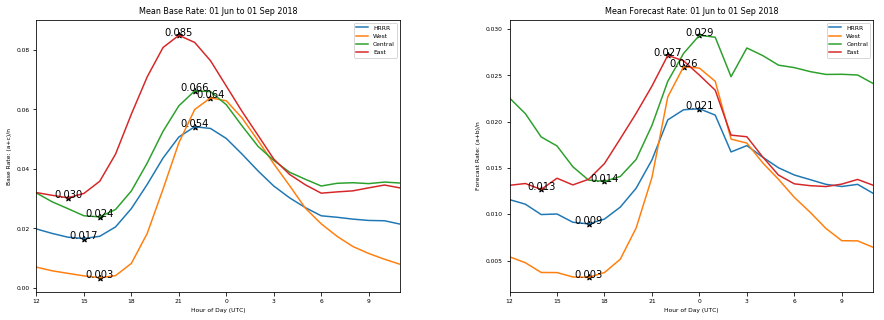

In [138]:
sDATE = datetime(2018, 6, 1)
eDATE = datetime(2018, 9, 1)

radii = [10, 20, 40]

domains = ['HRRR', 'West', 'Central', 'East']
labels = ['a)', 'b)', 'c)', 'd)']

#for DOMAIN, label, ax in zip(['HRRR'], ['a)'], [axes[0]]):

fig, axes = plt.subplots(1,2, figsize=(15,5))

for ax, data in zip(axes, ['Base Rate', 'Forecast Rate']):
    plt.sca(ax)
    for DOMAIN, label in zip(domains, labels):
        CT = get_traditional_scores(sDATE, eDATE, DOMAIN)

        print('---\n%s' % data)
        MAX = np.max(CT[data][0])
        MAXTIME = np.where(CT[data][0]==MAX)[0][0]
        MIN = np.min(CT[data][0])
        MINTIME = np.where(CT[data][0]==MIN)[0][0]

        plt.plot(range(26), CT[data][0], label=DOMAIN)
        plt.scatter(MAXTIME, MAX, marker='*', color='k')
        plt.text(MAXTIME, MAX, '%.3f' % MAX, ha='center')
        plt.scatter(MINTIME, MIN, marker='*', color='k')
        plt.text(MINTIME, MIN, '%.3f' % MIN, ha='center')

        print('%s Maximum %s: %.3f at %02d00 UTC' % (data, DOMAIN[:4], MAX, HOURS[MAXTIME]))
        print('%s Minimum %s: %.3f at %02d00 UTC' % (data, DOMAIN[:4], MIN, HOURS[MINTIME]))
        print()

    plt.legend()
    plt.xticks(np.arange(0,25,3), HOURS[::3])
    plt.xlim([0,23])
    if data=='Base Rate':
        plt.ylabel('%s: (a+c)/n' % data)
    elif data=='Forecast Rate':
        plt.ylabel('%s: (a+b)/n' % data)
    plt.xlabel('Hour of Day (UTC)')
    plt.title('Mean %s: %s to %s' % (data, sDATE.strftime('%d %b'), eDATE.strftime('%d %b %Y')))

plt.subplots_adjust(wspace=.3)
plt.savefig('./figs/not-shown_Mean-Base-Rate.png')

HRRR Maximum Forecast Rate: 0.021 at 1200 UTC
HRRR Minimum Forecast Rate: 0.009 at 0500 UTC



/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_wx_calcs/binary_events.py:127: RuntimeWarning: invalid value encountered in true_divide
  H = a/(a+c)
/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_wx_calcs/binary_events.py:112: RuntimeWarning: divide by zero encountered in true_divide
  B = (a+b)/(a+c)
/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_wx_calcs/binary_events.py:154: RuntimeWarning: invalid value encountered in true_divide
  FAR = b/(a+b)
/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_wx_calcs/binary_events.py:228: RuntimeWarning: invalid value encountered in true_divide
  GSS = (a-a_r)/(a+b+c-a_r)
/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_wx_calcs/binary_events.py:112: RuntimeWarning: invalid value encountered in true_divide
  B = (a+b)/(a+c)


West Maximum Forecast Rate: 0.026 at 1100 UTC
West Minimum Forecast Rate: 0.003 at 0500 UTC

Cent Maximum Forecast Rate: 0.029 at 1200 UTC
Cent Minimum Forecast Rate: 0.014 at 0600 UTC

East Maximum Forecast Rate: 0.027 at 1000 UTC
East Minimum Forecast Rate: 0.013 at 0200 UTC


Sta Date: 0000 UTC 01 June 2018
End Date: 0000 UTC 01 September 2018
Contingency Table Samples: 92


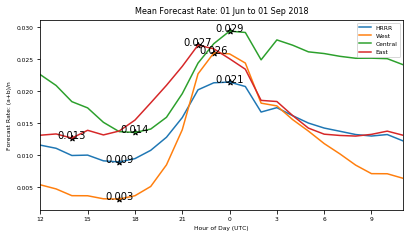

In [130]:
for DOMAIN, label, ax in zip(domains, labels, axes):
    CT = get_traditional_scores(sDATE, eDATE, DOMAIN)

    data = 'Forecast Rate'
    MAX = np.max(CT[data][0])
    MAXTIME = np.where(CT[data][0]==MAX)[0][0]
    MIN = np.min(CT[data][0])
    MINTIME = np.where(CT[data][0]==MIN)[0][0]

    plt.plot(range(26), CT[data][0], label=DOMAIN)
    plt.scatter(MAXTIME, MAX, marker='*', color='k')
    plt.text(MAXTIME, MAX, '%.3f' % MAX, ha='center')
    plt.scatter(MINTIME, MIN, marker='*', color='k')
    plt.text(MINTIME, MIN, '%.3f' % MIN, ha='center')
    
    print('%s Maximum Forecast Rate: %.3f at %02d00 UTC' % (DOMAIN[:4], MAX, MAXTIME))
    print('%s Minimum Forecast Rate: %.3f at %02d00 UTC' % (DOMAIN[:4], MIN, MINTIME))
    print()
    
plt.legend()
plt.xticks(np.arange(0,24,3), HOURS[::3])
plt.xlim([0,23])
plt.ylabel('Forecast Rate: (a+b)/n')
plt.xlabel('Hour of Day (UTC)')
plt.title('Mean Forecast Rate: %s to %s' % (sDATE.strftime('%d %b'), eDATE.strftime('%d %b %Y')))

fig.tight_layout()

plt.savefig('./figs/not-shown_Mean-Forecast-Rate.png')


print()    
print('Sta Date:', sDATE.strftime('%H%M UTC %d %B %Y'))
print('End Date:', eDATE.strftime('%H%M UTC %d %B %Y'))

# Numnber of samples
print('Contingency Table Samples:', len(CT['DATES']))

# Mean Frequency Bias
- Overforecast: B > 1 (red)
- Underforcast: B < 1 (blue)

/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_wx_calcs/binary_events.py:152: RuntimeWarning: invalid value encountered in true_divide
  FAR = b/(a+b)
/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_wx_calcs/binary_events.py:125: RuntimeWarning: invalid value encountered in true_divide
  H = a/(a+c)
/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_wx_calcs/binary_events.py:110: RuntimeWarning: divide by zero encountered in true_divide
  B = (a+b)/(a+c)
/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_wx_calcs/binary_events.py:226: RuntimeWarning: invalid value encountered in true_divide
  GSS = (a-a_r)/(a+b+c-a_r)
/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_wx_calcs/binary_events.py:110: RuntimeWarning: invalid value encountered in true_divide
  B = (a+b)/(a+c)


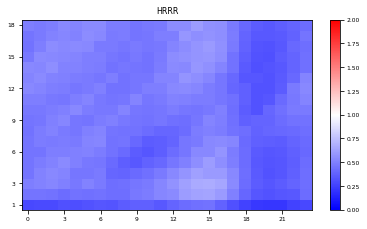

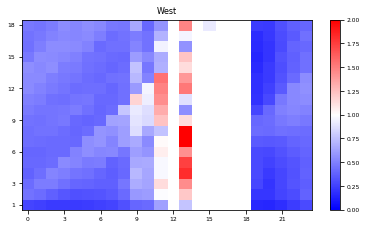

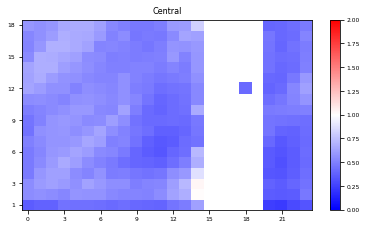

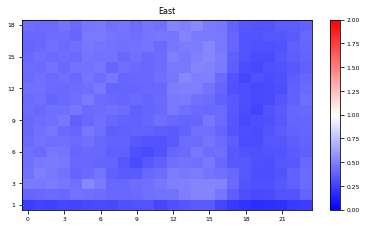

In [141]:
for i, DOMAIN in enumerate(domains):
    plt.figure(i)
    CT = get_traditional_scores(sDATE, eDATE, DOMAIN)
    plt.pcolormesh(range(25), range(1,20), CT['Frequency Bias'], vmax=2, vmin=0, cmap='bwr')
    plt.colorbar()
    
    plt.yticks(np.array([1, 3, 6, 9, 12, 15, 18])+.5, [1, 3, 6, 9, 12, 15, 18])
    plt.xticks(np.arange(0,24,3)+.5, range(0,24,3), )
    
    plt.title(DOMAIN)

In [142]:
CT = get_traditional_scores(sDATE, eDATE, 'West')

/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_wx_calcs/binary_events.py:152: RuntimeWarning: invalid value encountered in true_divide
  FAR = b/(a+b)
/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_wx_calcs/binary_events.py:125: RuntimeWarning: invalid value encountered in true_divide
  H = a/(a+c)
/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_wx_calcs/binary_events.py:110: RuntimeWarning: divide by zero encountered in true_divide
  B = (a+b)/(a+c)
/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_wx_calcs/binary_events.py:226: RuntimeWarning: invalid value encountered in true_divide
  GSS = (a-a_r)/(a+b+c-a_r)
/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_wx_calcs/binary_events.py:110: RuntimeWarning: invalid value encountered in true_divide
  B = (a+b)/(a+c)


In [143]:
CT['Frequency Bias']

array([[0.27119653, 0.25102387, 0.23091685, 0.22790623, 0.22710327,
        0.24063165, 0.25627539, 0.26784377, 0.3159766 , 0.40004751,
        0.4207723 , 0.62606801,        inf, 0.76711721,        inf,
               inf,        inf,        inf,        inf, 0.1592307 ,
        0.14972396, 0.18106053, 0.24021216, 0.29454876],
       [0.45266222, 0.42573768, 0.37884973, 0.34061143, 0.31715045,
        0.32518676, 0.33226937, 0.35927923, 0.42085855, 0.60050429,
        0.61520122, 0.98989459,        inf, 1.21524272,        inf,
               inf,        inf,        inf,        inf, 0.21585469,
        0.21618201, 0.26708896, 0.29773876, 0.38364153],
       [0.4278678 , 0.49070742, 0.48449648, 0.44088823, 0.39890233,
        0.39147479, 0.37566311, 0.37519873, 0.46354073, 0.67478074,
        0.6479152 , 1.13804732,        inf, 1.45133041,        inf,
               inf,        inf,        inf,        inf, 0.27724874,
        0.2094747 , 0.27352503, 0.32966207, 0.36897148],
       [0.389

# Hovmoller for 2019

Working on HRRR 2019-06-01 00:00:00 2019-08-04 00:00:00


/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_wx_calcs/binary_events.py:154: RuntimeWarning: invalid value encountered in true_divide
  FAR = b/(a+b)


saved: HRRR
Working on West 2019-06-01 00:00:00 2019-08-04 00:00:00


/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_wx_calcs/binary_events.py:127: RuntimeWarning: invalid value encountered in true_divide
  H = a/(a+c)
/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_wx_calcs/binary_events.py:228: RuntimeWarning: invalid value encountered in true_divide
  GSS = (a-a_r)/(a+b+c-a_r)
/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_wx_calcs/binary_events.py:112: RuntimeWarning: divide by zero encountered in true_divide
  B = (a+b)/(a+c)
/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_wx_calcs/binary_events.py:112: RuntimeWarning: invalid value encountered in true_divide
  B = (a+b)/(a+c)


saved: West
Working on Central 2019-06-01 00:00:00 2019-08-04 00:00:00
saved: Central
Working on East 2019-06-01 00:00:00 2019-08-04 00:00:00
saved: East
Sta Date: 0000 UTC 01 June 2019
End Date: 0000 UTC 04 August 2019
Contingency Table Samples: 62
       FSS Scores Samples: 64


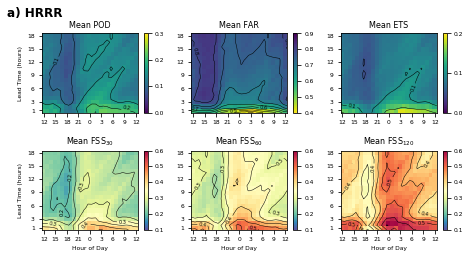

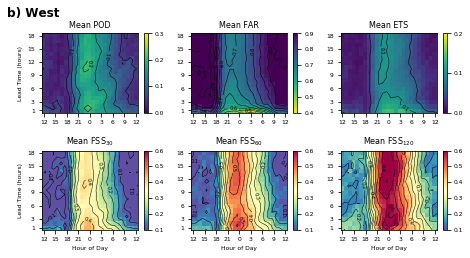

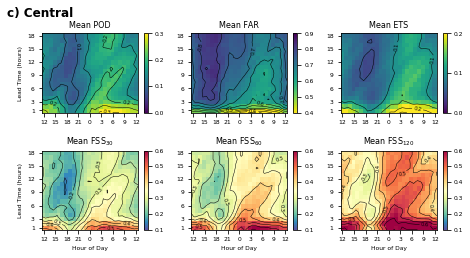

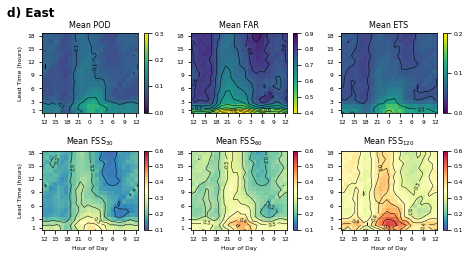

In [17]:
sDATE = datetime(2019, 6, 1)
eDATE = datetime(2019, 8, 4)

radii = [10, 20, 40]

domains = ['HRRR', 'West', 'Central', 'East']
labels = ['a)', 'b)', 'c)', 'd)']

# Hours plot order (plot maximum lightning in the center of the plot 1200 UTC to 1200 UTC and not 0000 UTC to 2400 UTC)
HOURS = list(range(12,24))+list(range(0,12))+[12, 13]

#for DOMAIN, label in zip(['HRRR'], ['a)']):
for DOMAIN, label in zip(domains, labels):
    print('Working on %s %s %s' % (DOMAIN, sDATE, eDATE))
    CT = get_traditional_scores(sDATE, eDATE, DOMAIN)
    FSS = {}
    for r in radii:
        FSS[r] = get_fss_scores(sDATE, eDATE, DOMAIN, r)
        
    #        [ax, data, vmax, vmin, cmap, name]
    plots = [[0, CT['POD'], 0.3, 0, 'viridis', 'POD'], 
             [1, CT['FAR'], .9, .4, 'viridis_r', 'FAR'], 
             [2, CT['ETS'], .2, 0, 'viridis', 'ETS']]
    
    for idx, r in zip(range(3,3+len(radii)), radii):
        plots.append([idx, FSS[r]['FSS'], .6, .1, 'Spectral_r', r'FSS$\mathregular{_{%s}}$' % (r*3)])


    fig, axes = plt.subplots(2,3)
    axes = axes.flatten()

    for p in plots:
        ax, data, vmax, vmin, cmap, name = p
        plt.sca(axes[ax])
        plt.pcolormesh(range(26), range(1,20), data, vmax=vmax, vmin=vmin, cmap=cmap)
        plt.colorbar(pad=.05, ticks=np.arange(vmin, vmax+.01, .1))

        # Plot Contour with label at 0.1 interval
        levels = np.arange(-.1,2,.1)
        CS = plt.contour(range(26), range(1,20), data, colors='k', linewidths=.5, levels=levels)
        plt.clabel(CS, fmt='%1.1f', fontsize=5, inline_spacing=1) # Only label every other
        # Plot Contour WITHOUT label at 0.05 interval
        levels = np.arange(-.15,2,.1)
        CS = plt.contour(range(26), range(1,20), data, colors='k', linewidths=.5, levels=levels)
        
        plt.yticks(np.array([1, 3, 6, 9, 12, 15, 18])+.5, [1, 3, 6, 9, 12, 15, 18])
        plt.xticks(np.array(range(0,25,3))+.5, np.array(HOURS[::3]), )

        if ax in [0, 3]:
            plt.ylabel('Lead Time (hours)')
        
        if ax in [3, 4, 5]:
            plt.xlabel('Hour of Day')
            
        plt.title('Mean %s' % name)

    plt.suptitle('%s %s' % (label, DOMAIN), y=1.01, x=0, ha='left', fontsize=12)
    fig.tight_layout()

    plt.savefig('./figs/not_shown_%s_HOV_skill_2019_%s.png' % (label[0],DOMAIN))
    print('saved:', DOMAIN)

    #if DOMAIN != 'HRRR':
    #    plt.close()
        
print('Sta Date:', sDATE.strftime('%H%M UTC %d %B %Y'))
print('End Date:', eDATE.strftime('%H%M UTC %d %B %Y'))

# Numnber of samples
print('Contingency Table Samples:', len(CT['DATES']))
print('       FSS Scores Samples:', len(FSS[10]['DATES']))